In [42]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn import tree
import random
import graphviz

%matplotlib inline

In [31]:
# PART 1: Retrieval
# Either load 1 dataset or all 15 files
LOAD_WHOLE_DATASET = True

# See data/REAMD.md for longer names/details.
columns = ['x', 'y', 'z', 'label']
# Index for persons
person_i = [i for i in range(1, 16)]
# Index for labels
label_i = [1, 2, 3, 4, 5, 6, 7]
labels = ['Computer', 'Moving', 'Standing', 'Walking', 'Stairs',
          'Walking + talking', 'Standing + talking']
labels_short = ['Computer', 'Move', 'Stand', 'Walk', 'Stairs',
          'Walk+talk', 'Stand+talk']
# Map numeric label to user friendly names
labels_map = {
    1: 'Computer',
    2: 'Moving',
    3: 'Standing',
    4: 'Walking',
    5: 'Stairs',
    6: 'Walking + talking',
    7: 'Standing + talking'
}
# Accelerations columns
accs = ['x', 'y', 'z']
# All pairs of accelerations
acc_pairs = [('x', 'y'), ('x', 'z'), ('y', 'z')]
# Map from label to a color, used in graphs
label_color = {
    'Computer': 'red',
    'Moving': 'green',
    'Standing': 'black',
    'Walking': 'yellow',
    'Stairs': 'cyan',
    'Walking + talking': 'orange',
    'Standing + talking': 'purple' ,
}

# find all csv files
if LOAD_WHOLE_DATASET:
    files = glob.glob('data/*.csv')
else:
    files = ['data/2.csv']

# concatenate all 15 data files
# usecols is used to skip reading the 'id' column, which has errors
person_datas = []
for file in files:
    person_data = pd.read_csv(file, sep=',', header=None, names=columns,
                 usecols=[1,2,3,4])
    # Add a column person, which specifies which dataset a row is from
    person_id = file.split('data/')[1].split('.csv')[0]
    print('Loading file', file)
    person_data['person'] = int(person_id)
    person_datas.append(person_data)
# Concatenate the data in ad variable (activity dataframe)
ad = pd.concat(person_datas, ignore_index=True)


Loading file data/14.csv
Loading file data/15.csv
Loading file data/2.csv
Loading file data/10.csv
Loading file data/12.csv
Loading file data/7.csv
Loading file data/1.csv
Loading file data/11.csv
Loading file data/5.csv
Loading file data/3.csv
Loading file data/9.csv
Loading file data/6.csv
Loading file data/4.csv
Loading file data/13.csv
Loading file data/8.csv


In [32]:
# Drop rows with not a valid label.
# Some rows have label '0', which is not a valid activity
ad = ad.loc[(ad['label'] >= 1) & (ad['label'] <= 7), :]

In [33]:
# Add new columns
# Add a readable label (string, not integer based)
ad['label_readable'] = ad['label'].map(labels_map)

# add a color to each class (label)
ad['color'] = ad['label_readable'].map(label_color)

In [34]:
# check data
print('\nShape')
print(ad.shape)
# Check head and tail
print('\nHead')
print(ad.head())
print('\nTail')
print(ad.tail())
# Check if any value is NaN, if this was the case those rows would need to be cleaned.
print('\nColumns with NaNs')
print(ad.isna().any())


Shape
(1923177, 7)

Head
      x     y     z  label  person label_readable color
0  1955  2302  1766      1      14       Computer   red
1  1954  2293  1770      1      14       Computer   red
2  1959  2298  1780      1      14       Computer   red
3  1954  2299  1774      1      14       Computer   red
4  1952  2301  1772      1      14       Computer   red

Tail
            x     y     z  label  person      label_readable   color
1926890  1700  1845  2034      7       8  Standing + talking  purple
1926891  1695  1844  2035      7       8  Standing + talking  purple
1926892  1700  1847  2034      7       8  Standing + talking  purple
1926893  1708  1849  2031      7       8  Standing + talking  purple
1926894  1709  1853  2026      7       8  Standing + talking  purple

Columns with NaNs
x                 False
y                 False
z                 False
label             False
person            False
label_readable    False
color             False
dtype: bool


In [38]:
# Investigate data, show data type, max/min, label count.
for column in columns:
    print()
    print(f"Column: {column}, dtype: {ad[column].dtype}")

    if column == 'label':
        print(f"Activity label count:\n{ad[column].value_counts()}")
    elif column in accs:
        print(column, 'min, max:', ad[column].min(), ad[column].max()),
        print(column, 'mean, std:', round(ad[column].mean(), 1), round(ad[column].std(), 1))

        print('Sorted head:')
        print(ad[column].sort_values().head(10))
        print('Sorted tail:')
        print(ad[column].sort_values().tail(10))


Column: x, dtype: int64
x min, max: 282 3828
x mean, std: 1987.5 111.3
Sorted head:
1459773    282
1459750    312
51         321
1459739    368
1459751    403
1459728    435
358491     483
1459761    494
50         516
358481     520
Name: x, dtype: int64
Sorted tail:
221869     3529
1790854    3566
221867     3577
1790866    3603
1790830    3618
221868     3625
358486     3626
358496     3637
358497     3674
1790867    3828
Name: x, dtype: int64

Column: y, dtype: int64
y min, max: 2 4095
y mean, std: 2382.3 100.2
Sorted head:
221874    2
221850    2
221851    2
221873    2
221863    2
358470    2
358471    2
221862    2
358481    2
358480    2
Name: y, dtype: int64
Sorted tail:
358477    4087
221867    4091
358475    4093
221868    4094
358486    4094
358487    4094
358496    4094
358485    4095
358476    4095
358497    4095
Name: y, dtype: int64

Column: z, dtype: int64
z min, max: 1 4095
z mean, std: 1970.5 94.5
Sorted head:
1459766    1
1459755    2
1790824    2
1790825    2
1790

In [39]:
# From the output above we can see the data is unbalanced, 'moving' has 928 data points,
# while 'standing + walking' has 83748. When using knn, the feature with most
# data points will be favoured.

# We also see that y, z have data points which seem faulty. There are a few of
# abnormally small and big values (e.g. 2 and 4095).

# We can investigate the abnormal y and z values further:
outs_y = ad.loc[(ad['y'] > 3800) | (ad['y'] < 200), :]
outs_z = ad.loc[(ad['z'] > 3800) | (ad['z'] < 200), :]
print('\ny outliers:')
print(outs_y.sort_values(by='y'))
print('z outliers:')
print(outs_z.sort_values(by='z'))
# We see they often correlate, a small y follows a big z, and vice versa,
# but not always. All are for 'Computer' class


y outliers:
            x     y     z  label  person label_readable color
358481    520     2  1768      1      10       Computer   red
221874   1114     2  4093      1       2       Computer   red
221873   1095     2  4094      1       2       Computer   red
358480    583     2  1315      1      10       Computer   red
358470    804     2  1272      1      10       Computer   red
221863   1141     2  4092      1       2       Computer   red
358471    799     2  1681      1      10       Computer   red
221851   1753     2  3622      1       2       Computer   red
221850   2055     2  3304      1       2       Computer   red
221862   1094     2  4094      1       2       Computer   red
358491    483    74  1852      1      10       Computer   red
1459756  2989   146     2      1       6       Computer   red
358464   2680  3805  2451      1      10       Computer   red
358466   2650  3810  1631      1      10       Computer   red
1459751   403  3829  3476      1       6       Computer  

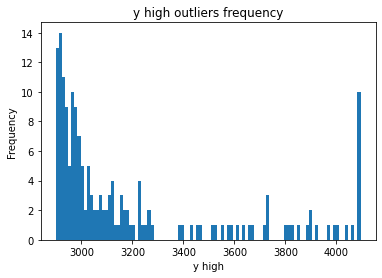

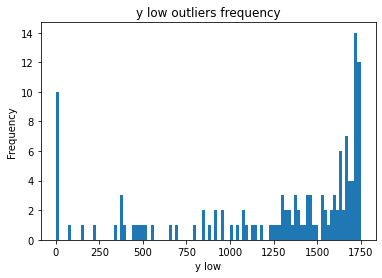

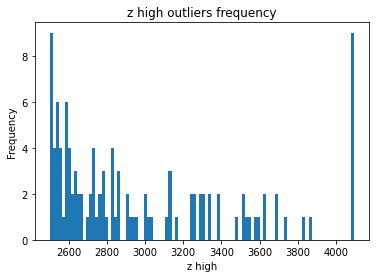

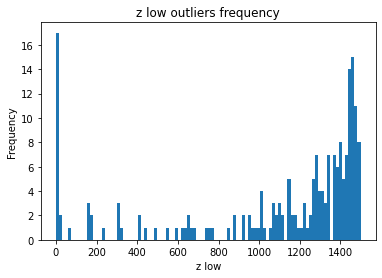

In [40]:
# I will investigate further, and look at the distribution
# of the outliers. 
outs_yh = ad.loc[(ad['y'] > 2900), 'y']
outs_yl = ad.loc[(ad['y'] < 1750), 'y']
outs_zh = ad.loc[(ad['z'] > 2500), 'z']
outs_zl = ad.loc[(ad['z'] < 1500), 'z']


# In the figure below we can see the frequency distribution 
# for y in the range above 2900. This shows the outliers mentioned above, 
# and clearly shows that they differ from the data points around it. 
# Similar graphs are made for low y-values, high and low z-values.
# Further exploration is done in the single column exploration
outs_yh.plot.hist(bins=100)
plt.title('y high outliers frequency')
plt.xlabel('y high')
#plt.savefig('pic/y_high_outlier')
plt.show()


outs_yl.plot.hist(bins=100)
plt.title('y low outliers frequency')
plt.xlabel('y low')
plt.show()


outs_zh.plot.hist(bins=100)
plt.title('z high outliers frequency')
plt.xlabel('z high')
plt.show()


outs_zl.plot.hist(bins=100)
plt.title('z low outliers frequency')
plt.xlabel('z low')
plt.show()

In [ ]:
# TASK 2: DATA EXPLORATION
# EXPLORE EACH COLUMN
# EXPLORE RELASTIONSHIPS BETWEEN ALL PAIR OF COLUMNS

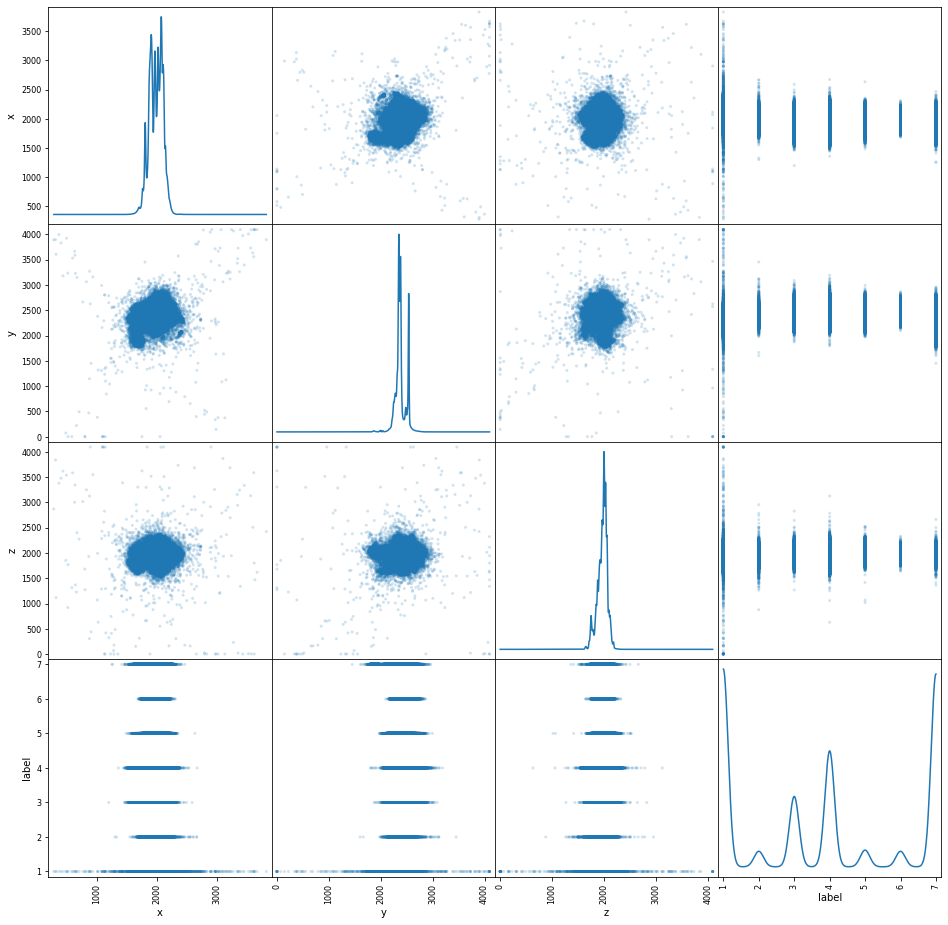

In [46]:
# Generate a scatter matrix to get a quick overview
scatter_matrix(ad.loc[:, ['x', 'y', 'z', 'label']], alpha=.2, figsize=(16,16), diagonal='kde');
#plt.savefig('pic/scattermatrix.png')

In [ ]:
# Explore acceleration data point distribution
def explore_acc(acceleration):
    print('Exploring feature: ', acceleration)
    feat = ad[acceleration]
    print(f"{acceleration} min: {ad[acceleration].min()}, max: {ad[acceleration].max()}")
    # show frequency distribution
    print(feat.value_counts(bins=20, normalize=True, sort=False))
    # plot distribution
    print(feat.plot.hist(bins=100))
    plt.xlabel(f"{acceleration} acceleration")
    plt.ylabel('Frequency')

    plt.title(f"{acceleration} acceleration frequency distribution")
    plt.tight_layout()

    plt.savefig(f"pic/{acceleration}-histogram")
    plt.show()

for acc in accs:
    explore_acc(acc)

In [ ]:
# Explore class types and distribution  in barplot
fig, ax = plt.subplots()
ad['label_readable'].value_counts().plot.bar()
ax.set_xticklabels(labels_short)
plt.title('Class frequency')
plt.ylabel('Frequency')
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('pic/class-bar-chart')

In [ ]:
# Explore pair of attributes (columns)
# plot class against each acceleration
for acc in accs:
    fig, ax = plt.subplots(figsize=(8,6))
    ad.boxplot(column=acc, by='label_readable', ax=ax, grid=False)
    ax.set_xticklabels(labels_short)
    plt.xlabel('Activity')
    plt.ylabel('Acceleration value')
    plt.title(f"Distribution of {acc} acceleration for each class of movement")
    plt.suptitle('')
    #plt.savefig(f"pic/{acc}-class-boxplot")
    fig.show()

In [ ]:
# Shows distribution of accelerations for each activity.
for label in labels:
    label_acc = ad.loc[ad['label_readable'] == label, accs]
    fig, ax = plt.subplots()
    label_acc.boxplot(grid=False)
    plt.xlabel('Acceleration axis')
    plt.ylabel('Acceleration value')
    plt.title(f"Distribution of {label} acceleration for each axis of acceleration")
    plt.suptitle('')
    plt.show()

In [ ]:
# TASK: Explore the relationship between all pairs of attributes
# Compare class label, vs accelerations
# Hypothesis: my hypothesis is that activities where the participants move will have the most variance.  
# Result: This type of graph is not suited, it gives unexpected and most likely wrong result

acc_pairs = [('x', 'y'), ('x', 'z'), ('y', 'z')]
for acc1, acc2 in acc_pairs:
    fig, ax = plt.subplots()
    ax.scatter(x=ad[acc1], y=ad[acc2], c=ad['color'], alpha=0.4)
    plt.title(f"Acceleration: {acc1} vs {acc2} by activity")
    plt.xlabel(f"{acc1}")
    plt.ylabel(f"{acc2}")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    #retrieve values from color dictionary and attribute it to corresponding labels
    leg_el = [mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) for key, value in label_color.items()]
    
    # Put a legend to the right of the current axis
    ax.legend(handles = leg_el, loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.savefig(f"pic/{acc1}-{acc2}-class-colour-scatter-(all: {LOAD_SINGLE_DATASET})")
    plt.show()

In [ ]:
# Hypothesis: I expect to see some relationship between accelerations, eg.
# walking in stairs would have both x acc and y acc higher.
for acc in accs:
    for acc2 in accs:
        if acc == acc2: continue
        ad.plot.scatter(x=acc, y=acc2)
        plt.title(f"Acceleration: {acc} vs {acc2}")
        plt.xlabel(f"{acc}")
        plt.ylabel(f"{acc2}")
        plt.show()

In [ ]:
# Plot line chart for each person, for each activity, with all accelerations in one graph
for p in range(1, 16):
    for activity in labels:
        fig, ax = plt.subplots()
        plt.title(f"Person: {p}, Activity: {activity}")
        d  = ad.loc[(ad['person'] == p) & (ad['label_readable'] == activity), accs].reset_index()
        for acc in accs:
            ds = d[acc]
            ds.plot(label=acc)
        plt.legend()
        plt.ylim(0, 4100)
        plt.xlabel('Sequential measurement nr.')
        plt.ylabel('Acceleration')
        plt.show()


In [ ]:
# Plot line chart for each activity (combine all persons), with all accelerations in one graph
for activity in labels:
    fig, ax = plt.subplots()
    plt.title(f"Activity: {activity}")
    d  = ad.loc[ad['label_readable'] == activity, accs].reset_index()
    for acc in accs:
        ds = d[acc]
        ds.plot(label=acc)
    plt.legend()
    plt.ylim(0, 4100)
    plt.xlabel('Sequential measurement nr.')
    plt.ylabel('Acceleration')
    plt.show()

In [ ]:
# Plot line chart for pair of accelerations, for each activity
for activity in labels:
    d  = ad.loc[ad['label_readable'] == activity, accs].reset_index()
    for acc1, acc2 in acc_pairs:
        ds = d[[acc1, acc2]].plot()
        
        plt.title(f"{activity}, acceleration {acc1} vs. {acc2}")
        plt.legend()
        plt.ylim(0, 4100)
        plt.xlabel('Sequential measurement nr.')
        plt.ylabel('Acceleration')
        plt.tight_layout()
        plt.savefig(f"pic/{activity}-{acc1}-{acc2}")
        plt.show()

In [ ]:
# Plot line chart for pairs of 1 acceleration and 1 activity
for activity in labels:
    d  = ad.loc[ad['label_readable'] == activity, accs].reset_index()
    for acc in accs:
        d[acc].plot(label=acc)
        plt.title(f"Activity: {activity}, acceleration {acc}")
        plt.legend()
        plt.ylim(0, 4100)
        plt.xlabel('Sequential measurement nr.')
        plt.ylabel('Acceleration')
        plt.tight_layout()
        plt.savefig(f'pic/{activity}-{acc}')
        plt.show()

In [ ]:
# 3D plot for all 3 accelerations
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(ad['x'], ad['y'], ad['z'], c=ad['color'], alpha=.2)
plt.title(f"Acceleration: x, y, z by class")
ax.set_xlabel(f"x acceleration ")
ax.set_ylabel(f"y acceleration ")
ax.set_zlabel('z acceleration ')
leg_el = [mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) for key, value in label_color.items()]
# Put a legend to the right of the current axis
ax.legend(handles = leg_el, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(f"3d-scatter")
plt.show()

In [ ]:
# TASK 3: MODELING
# The goal of the modeling is to see if it is possible to classify an unknown
# activity based on a set of data points. This is classification, so possible
# models are knn, decision tree.

In [ ]:
# FEATURE EXTRACTION
# Extract features for data modeling
# this method takes a dataframe for 1 person, windows it, and returns a new dataframe with new features
# wsize defaults to 1 second (=52 Hz)
# returns mean, std, max-min,
def windowing(df, wsize=52):
    person = df['person'][0] # get person id
    df_list = []  # storing dicts in a list then creating dataframe in the end is much faster
    
    # iterate over all activities
    for label in label_i:
        # extract label activity
        df_t = df.loc[df['label'] == label, :].reset_index()
        label_readable, color = df_t['label_readable'][0], df_t['color'][0]
        
        slide = 0  # slide will slide over the time series, increasing wsize//2 each iteration
        window = wsize
        size = len(df_t.index)
        while slide < size:
            # extract window frame
            rows = df_t.iloc[slide:window][accs]
            if len(rows) < 2: break
            df_list.append({
                'person': person,
                'label': label,
                'label_readable': label_readable,
                'color': color,
                'x mean': rows['x'].mean(),
                'y mean': rows['y'].mean(),
                'z mean': rows['z'].mean(),
                'x std': rows['x'].std(),
                'y std': rows['y'].std(),
                'z std': rows['z'].std(),
                'x diff': rows['x'].max() - rows['x'].min(),
                'y diff': rows['y'].max() - rows['y'].min(),
                'z diff': rows['z'].max() - rows['z'].min(),
                })
            # move window
            window = slide + wsize
            slide += wsize//2
    return pd.DataFrame(df_list)
        
ad_l = []
for person in person_i:
    print(f"Computing new features for person {person}")
    ad_l.append(windowing(ad.loc[ad['person'] == person, :],  wsize=52))
# Store new features in ad_n, set new indexes
ad_n = pd.concat(ad_l, ignore_index=True)

In [ ]:
# Inspect features extracted
# Compare means in scatter plot
acc_pairs = [('x mean', 'y mean'), ('x mean', 'z mean'), ('y mean', 'z mean')]
acc_pairs_std = [('x std', 'y std'), ('x std', 'z std'), ('y std', 'z std')]
acc_pairs_diff = [('x diff', 'y diff'), ('x diff', 'z diff'), ('y diff', 'z diff')]
# change acc_pairs to inspect different feature
for acc1, acc2 in acc_pairs:
    fig, ax = plt.subplots()
    ax.scatter(x=ad_n[acc1], y=ad_n[acc2], c=ad_n['color'], alpha=0.4)
    plt.title(f"Acceleration: {acc1} vs {acc2} by activity (windowed)")
    plt.xlabel(f"{acc1}")
    plt.ylabel(f"{acc2}")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    #retrieve values from color dictionary and attribute it to corresponding labels
    leg_el = [mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) for key, value in label_color.items()]
    
    # Put a legend to the right of the current axis
    ax.legend(handles = leg_el, loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.savefig(f"{acc1}-{acc2}-class-colour-scatter-(all: {LOAD_SINGLE_DATASET})")
    plt.show()

# These plots, compared to the plots of x,y,z acceleration, shows that
# the new features are more diversified/separated. So likely will give better results

In [ ]:
# Inspect features extracted
# Boxplot of means, std, or diff
means = ['x mean', 'y mean', 'z mean']
stds = ['x std', 'y std', 'z std']
diffs = ['x diff', 'y diff', 'z diff']
for mean in means:
    fig, ax = plt.subplots(figsize=(8,6))
    ad_n.boxplot(column=mean, by='label_readable', ax=ax, grid=False)
    ax.set_xticklabels(labels_short)
    plt.xlabel('Activity')
    plt.ylabel('Acceleration mean value (windowed)')
    plt.title(f"Distribution of {mean} acceleration for each class of movement")
    plt.suptitle('')
    #plt.savefig(f"{mean}-class-boxplot")
    fig.show()
    #break

In [ ]:
# Inspect features extracted
# 3D plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(ad_n['x mean'], ad_n['y mean'], ad_n['z mean'], c=ad_n['color'], alpha=.2)
plt.title(f"Acceleration: x, y, z  mean by class (windowed)")
ax.set_xlabel(f"x acceleration mean")
ax.set_ylabel(f"y acceleration mean")
ax.set_zlabel('z acceleration mean')
leg_el = [mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) for key, value in label_color.items()]
# Put a legend to the right of the current axis
ax.legend(handles = leg_el, loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig(f"3d-scatter-mean-windowed")
plt.show()


In [ ]:
# Define global X = feature rows, y = label rows
X = ad_n.iloc[:, 4:]
y = ad_n.loc[:, 'label']

In [ ]:
# SELECTING FEATURES FOR MODELING
# Feature selection with hill climbing

# pass in feature columns, target column, classifier, and a function returning a number
# This method returns a list of features removed
def feature_hill_climbing(data, target, classifier, random_func):

    data_columns = data.columns
    num_features = len(data_columns)

    new_index = []
    removed = []
    max_score = 0.0
    feature_index_random = shuffle(data_columns, random_state=random_func())

    for feature_index in range(num_features):
        new_index.append(feature_index_random[feature_index])
        new_data = data.loc[:, new_index]
        X_train, X_test, y_train, y_test = train_test_split(
            new_data, target, random_state=random_func())

        fit = classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)
        if score < max_score:
            new_index.remove(feature_index_random[feature_index])
            removed.append(feature_index_random[feature_index])
        else:
            max_score = score
            #print(f"Score with {len(new_index)} selected features: {score}")
    #print('Selected features:')
    #print(sorted(new_index))
    #print('Removed: ', removed)
    print('Max score:', max_score, 'Features:', len(new_index))
    return removed


In [ ]:
# This method is used both to test different number of neighbours, and to test a specific 
# number of neighbours N times to find the best features to use
def test_knn_n_neighbours():
    features_removed = {f: 0 for f in X.columns}
    # Test different sets of neightours, or use it to run N itmes
    neighbors = 3
    for i in range(1,20):
        #print(f'Testing with {i} neighbours')
        #knnc = KNeighborsClassifier(n_neighbors=i, weights='distance', p=2)
        
        print(f'Iteration {i} with {neighbors} neighbours')
        knnc = KNeighborsClassifier(n_neighbors=neighbors, weights='distance', p=2)
        
        removed = feature_hill_climbing(X, y, knnc, random_func=lambda : random.randint(0,1000))
        print(removed)
        for feature in removed:
            features_removed[feature] += 1
    # print how often a feature was removed
    for key, value in features_removed.items():
        if value > 0:
            print(key, value)

def test_dt_max_depth():
    features_removed = {f: 0 for f in X.columns}
    depth = 5
    # Test different sets of neightours
    for i in range(1,30):
        print(f'Testing with {i} depth')
        dtc = DecisionTreeClassifier(max_depth=i, min_samples_split=40)

        #print(f'Iteration {i}')
        #dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=2000)
        
        removed = feature_hill_climbing(X, y, dtc, random_func=lambda : random.randint(0,1000))
        print(sorted(removed))
        for feature in removed:
            features_removed[feature] += 1
    # print how often a feature was removed
    for key, value in features_removed.items():
        if value > 0:
            print(key, value)

#test_knn_n_neighbours()
test_dt_max_depth()

# knn: use all 6, remove diff. N-neighbors=3
# decision tree: use 6 features, remove ['y std', 'z diff', 'z std']. Depth=5

In [ ]:
# Extract selected features for each model:
# KNN:
X_knn = X.loc[:, ['x mean', 'y mean', 'z mean', 'x std', 'y std', 'z std']]
# Decision Tree:
X_dt = X.loc[:, ['x mean', 'y mean', 'z mean', 'x std', 'x diff', 'y diff']]

In [ ]:
# K-Folds cross validation
def k_folds(data, target, classifier, folds=5):
    sum = 0
    # Super important to set shuffle=True, since it does not shuffle by defalut!
    kf = KFold(n_splits=folds, shuffle=True, random_state=random.randint(0, 1000))
    for k, (train_index, test_index) in enumerate(kf.split(data)):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        fit = classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)
        sum += score
        print(f"[Fold {k}] score:    {score}")
    print(f"Average ({folds} folds): {sum/(folds)}")

In [ ]:
# VALIDATE SELECTED FEATURES AND PARAMETERS
# Test Knn k-folds
neighbours = 3
weights = 'distance'
p = 2
knnc = KNeighborsClassifier(n_neighbors=neighbours, weights=weights, p=p)
k_folds(X_knn, y, knnc, folds=10)

# Give good performance with n_neighbors=3, weights=distance, p=2

In [ ]:
# VALIDATE SELECTED FEATURES AND PARAMETERS

# Test decision tree k-folds
max_depth = 5
min_samples_split = 40
dtc = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
k_folds(X_dt, y, dtc, folds=10)

# Ok performance with max_depth=5, min_samples_split=40
#

In [ ]:
# GENERATE MODEL AND EVALUATE
# KNN, 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, random_state=0, test_size=0.2)

clf = KNeighborsClassifier(
    n_neighbors=neighbours, 
    weights=weights,
    p=p
)
fit = clf.fit(X_train, y_train)
y_pred = fit.predict(X_test)
print('Score:', clf.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels_short))

In [ ]:
# GENERATE MODEL AND EVALUATE

# Decision tree, 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_dt, y, random_state=0, test_size=0.2)

clf = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_split=min_samples_split
)

fit = clf.fit(X_train, y_train)
y_pred = fit.predict(X_test)
print('Score:', clf.score(X_test, y_test))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=labels_short))

In [ ]:
# save decision tree

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X_dt.columns, class_names=labels,
                             filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph


In [ ]:
# ADDENDUM
# Here is the test result with just using the raw x,y,z values, without
# feature extraction.

# Try to model RAW data -> result: low model score
X = ad.iloc[:, :3]
y = ad.loc[:, 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# KNN
clf = KNeighborsClassifier(
    n_neighbors=3
)
fit = clf.fit(X_train, y_train)
y_pred = fit.predict(X_test)
print('Knn score:', clf.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels_short))

# Decision tree
clf = DecisionTreeClassifier(
    max_depth=5
)

fit = clf.fit(X_train, y_train)
y_pred = fit.predict(X_test)
print('DT score:', clf.score(X_test, y_test))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=labels_short))
